# Example 2.7

Import Tensorflow and all necessary packages

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.layers.experimental import preprocessing
import os
import IPython

Define functions

Execute the next line only if you want to use a GPU for the training

In [2]:
##IF GPU:
physical_devices = tf.config.list_physical_devices('GPU') 

# Basket Option Model

First define a function to read the data

In [3]:
# # Read Data
def read_data(xpath,ypath):
    file_dir = os.path.dirname(os.path.abspath("__file__"))
    csv_folder = "csv"
   
    file_path_x = os.path.join(file_dir, csv_folder, xpath)
    df_x = pd.read_csv(file_path_x, header=None)
    df_x = df_x.dropna()
    weighted_spot = (df_x.iloc[:,0]*df_x.iloc[:,2]+df_x.iloc[:,1]*df_x.iloc[:,3])  
    file_path_y = os.path.join(file_dir, csv_folder,ypath)
    df_y = pd.read_csv(file_path_y, header=None)
    df_y = df_y.dropna()   

    return df_x,df_y

Then define a function to build a deep learning model, include Batch Normalization

Read the data

In [4]:
X_train_basket,y_train_basket = read_data('x_train.csv','y_train.csv')
X_test_basket,y_test_basket = read_data('x_test.csv','y_test.csv')

X_train_basket, y_train_basket = shuffle(X_train_basket,y_train_basket)
X_test_basket, y_test_basket = shuffle(X_test_basket,y_test_basket)
# Consider 150 000 for training, 10 000 for testing ....
X_train_basket = X_train_basket.iloc[:150000,:]
y_train_basket = y_train_basket.iloc[:150000,:]
X_test_basket = X_test_basket.iloc[:10000,:]
y_test_basket = y_test_basket.iloc[:10000,:]

In [5]:
def compute_price_from_strat(data_row,strategy_row):
    length = len(strategy_row)
    weights_lower_bound = np.array(strategy_row[:int(length/2)])
    weights_upper_bound = np.array(strategy_row[int(length/2):])
    S_1 = data_row[0]
    S_2 = data_row[1]
    lower_bound = 0
    lower_bound += weights_lower_bound[0]*1+weights_lower_bound[1]*S_1+weights_lower_bound[2]*S_2
    lower_bound += np.sum([weights_lower_bound[3+i]*(data_row[45+i]*(weights_lower_bound[3+i]>0)+data_row[85+i]*(weights_lower_bound[3+i]<0)) for i in range(40)])
    upper_bound = 0
    upper_bound += weights_upper_bound[0]*1+weights_upper_bound[1]*S_1+weights_upper_bound[2]*S_2
    upper_bound += np.sum([weights_upper_bound[3+i]*(data_row[45+i]*(weights_upper_bound[3+i]>0)+data_row[85+i]*(weights_upper_bound[3+i]<0)) for i in range(40)])
    return -lower_bound, upper_bound

Convert the y - vector of strategies into a vector of prices

In [6]:
y_test_basket_prices = [compute_price_from_strat(X_test_basket.iloc[i,:],y_test_basket.iloc[i,:]) for i in range(len(X_test_basket))]
y_test_basket_prices = pd.DataFrame(y_test_basket_prices)

We write a function that builds a deep learning model to directly learn the prices

In [7]:
def build_model_prices(x,nr_neurons = 256,reg_param=0.00):
    model = keras.Sequential([
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param),activation='relu',input_shape=[125]),
        layers.BatchNormalization(),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(2)
      ])
    model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mae', 'mse'])
    scaler = StandardScaler().fit(x)
    return model, scaler

In [8]:
_, scaler_basket = build_model_prices(X_train_basket,5,0)
X_train_basket_scaled  = scaler_basket.transform(X_train_basket)
X_test_basket_scaled = scaler_basket.transform(X_test_basket)

Load the model for the basket options

In [9]:
model_basket=keras.models.load_model('model_basket_prices.h5')

# Call Option Model

In [10]:
# # Read Data
def read_data_call(xpath,ypath):
    df_x = pd.read_csv(xpath, header=None)
    df_x = df_x.dropna()

    df_y = pd.read_csv(ypath, header=None)
    df_y = df_y.dropna()
    
    
    # Deleting Errrative Scenarios
    df_x = df_x.drop(df_x[df_y.iloc[:,0] < 0].index)
    df_y = df_y.drop(df_y[df_y.iloc[:,0] < 0].index)
    
    return df_x,df_y

In [11]:
def build_model_call(x,nr_neurons = 256,reg_param=0.00):

    model = keras.Sequential([
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param),activation='relu',input_shape=[62]),
        layers.BatchNormalization(),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(nr_neurons,kernel_regularizer=regularizers.l2(reg_param), activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(2)
      ])
    model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mae', 'mse'])
    scaler = StandardScaler().fit(x)
    return model, scaler

In [12]:
X_train_call,y_train_call = read_data('x_train_calls.csv','y_train_calls.csv')
X_test_call,y_test_call = read_data('x_test_calls.csv','y_test_calls.csv')
# Only consider 100 000 for training, 10 000 for testing
X_train_call, y_train_call = shuffle(X_train_call,y_train_call)
X_train_call = X_train_call.iloc[:100000,:]
y_train_call = y_train_call.iloc[:100000,:]
X_test_call = X_test_call.iloc[:10000,:]
y_test_call = y_test_call.iloc[:10000,:]
_, scaler_call = build_model_call(X_train_call,1,0)
X_train_call_scaled = scaler_call.transform(X_train_call)
X_test_call_scaled = scaler_call.transform(X_test_call)

In [13]:
model_call=keras.models.load_model('model_call_options.h5')

# Convert Call Option Data to Basket Option Format

In [14]:
def convert_call_to_basket_input(x,non_random = False):
    weights = np.random.uniform([0]*len(x))
    if non_random:
        weights = np.array([0.5]*len(x))
    x_mod = x.reset_index(drop = True)
    x_mod = pd.concat([x_mod.iloc[:,0],
                      x_mod.iloc[:,0],
                      pd.Series(weights),
                      pd.Series(1-weights),
                      x_mod.iloc[:,21],
                      x_mod.iloc[:,1:21],
                      x_mod.iloc[:,1:21],
                      x_mod.iloc[:,22:42],
                      x_mod.iloc[:,22:42],
                      x_mod.iloc[:,42:],
                      x_mod.iloc[:,42:]],1)
    x_mod = x_mod.set_axis([i for i in range(len(x_mod.columns))], 
                                                       axis=1, inplace=False)
    return x_mod

X_test_call_to_basket = convert_call_to_basket_input(X_test_call,non_random = True)
X_test_call_to_basket_scaled = scaler_basket.transform(X_test_call_to_basket)

# Test the Predictions

In [15]:
test_predictions_basket_to_call = model_basket.predict(X_test_call_to_basket_scaled)
mae_basket_to_call = np.mean(np.mean(np.abs(test_predictions_basket_to_call - y_test_call)))
rae_basket_to_call = np.mean(np.mean(np.abs(test_predictions_basket_to_call - y_test_call)/np.stack([X_test_call.iloc[:,0],X_test_call.iloc[:,0]],1)))
rse_basket_to_call = np.mean(np.mean(np.square((test_predictions_basket_to_call - y_test_call)/np.stack([X_test_call.iloc[:,0],X_test_call.iloc[:,0]],1))))
print("-- Basket to Call: --\n")
print("mean absolute error:{}\n".format(mae_basket_to_call))
print("relative mean absolute error:{}\n".format(rae_basket_to_call))
print("relative mean squared error:{}\n".format(rse_basket_to_call))

-- Basket to Call: --

mean absolute error:3.9861626489454807

relative mean absolute error:0.023087250738060575

relative mean squared error:0.002312961651532598



In [16]:
test_predictions_call = model_call.predict(X_test_call_scaled)
mae_call = np.mean(np.mean(np.abs(test_predictions_call - y_test_call)))
rae_call = np.mean(np.mean(np.abs(test_predictions_call - y_test_call)/np.stack([X_test_call.iloc[:,0],X_test_call.iloc[:,0]],1)))
rse_call = np.mean(np.mean(np.square((test_predictions_call - y_test_call)/np.stack([X_test_call.iloc[:,0],X_test_call.iloc[:,0]],1))))
print("-- Calls: --\n")
print("mean absolute error:{}\n".format(mae_call))
print("relative mean absolute error:{}\n".format(rae_call))
print("relative mean squared error:{}\n".format(rse_call))

-- Calls: --

mean absolute error:2.249915529362677

relative mean absolute error:0.011402019018801605

relative mean squared error:0.00034402501006465134



Model Evaluation 
 
Relative Mean absolute Error:
0.023087250738060578
Model Evaluation 
 
Relative Mean squared Error:
0.0023129616515325992


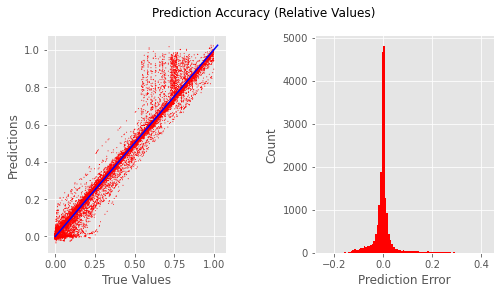

In [17]:
# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)



#Along a line
test_predictions_relative =  model_basket.predict(X_test_call_to_basket_scaled).flatten('F')/np.concatenate((np.array(X_test_call.iloc[:,0]),np.array(X_test_call.iloc[:,0])))
y_test_relative =  np.array(y_test_call).flatten('F')/np.concatenate((np.array(X_test_call.iloc[:,0]),np.array(X_test_call.iloc[:,0])))

#a = plt.axes(aspect='equal')
axs[0].plot([0,max(test_predictions_relative)],[0,max(test_predictions_relative)],color = "blue")
axs[0].scatter(y_test_relative, test_predictions_relative,c=['red']*len(y_test_call)*2,s=1, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')


# Histogram
error = np.array(test_predictions_relative - y_test_relative)
axs[1].hist(error, bins = 100,color='red')
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy (Relative Values)')
plt.savefig('accuracy_relative_spot_call_options_basket_to_calls.eps', format='eps')

# Evaluate the model
print("Model Evaluation \n \nRelative Mean absolute Error:")
print(np.mean(np.abs(test_predictions_relative - y_test_relative)))

# Evaluate the model
print("Model Evaluation \n \nRelative Mean squared Error:")
print(np.mean(np.square(test_predictions_relative - y_test_relative)))

# Train an (improved) model also on call option training set

adjust the training set by adding call options to it

In [18]:
X_train_improved = pd.concat([X_train_basket,convert_call_to_basket_input(X_train_call)])
y_train_basket = [compute_price_from_strat(X_train_basket.iloc[i,:],y_train_basket.iloc[i,:]) for i in range(len(X_train_basket))]
y_train_basket = pd.DataFrame(y_train_basket)
y_train_improved = pd.concat([y_train_basket,y_train_call])

Shuffle and Scale the training data

In [19]:
neurons = 512
regul = 0
BATCH_SIZE = 256

model_improved, scaler_improved = build_model_prices(X_train_improved,neurons,regul)
X_train_improved, y_train_improved = shuffle(X_train_improved, y_train_improved)
X_train_improved_scaled  = scaler_improved.transform(X_train_improved)

Train the new neural network

In [20]:
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model_improved.fit(X_train_improved_scaled, y_train_improved,  epochs=EPOCHS,batch_size=BATCH_SIZE,
                    validation_split = 0.1, verbose=1,callbacks = [early_stop])
model_improved.save("model_improved.h5")

Epoch 1/1000
879/879 [==============================] - 11s 12ms/step - loss: 437.6903 - mae: 12.8744 - mse: 437.6903 - val_loss: 140.3842 - val_mae: 7.3011 - val_mse: 140.3842
Epoch 2/1000
879/879 [==============================] - 10s 11ms/step - loss: 72.3032 - mae: 5.0895 - mse: 72.3032 - val_loss: 57.3936 - val_mae: 5.3171 - val_mse: 57.3936
Epoch 3/1000
879/879 [==============================] - 10s 11ms/step - loss: 63.7793 - mae: 4.9256 - mse: 63.7793 - val_loss: 54.8671 - val_mae: 5.1330 - val_mse: 54.8671
Epoch 4/1000
879/879 [==============================] - 10s 12ms/step - loss: 56.5151 - mae: 4.6474 - mse: 56.5151 - val_loss: 23.7964 - val_mae: 2.9724 - val_mse: 23.7964
Epoch 5/1000
879/879 [==============================] - 10s 12ms/step - loss: 46.8992 - mae: 4.3712 - mse: 46.8992 - val_loss: 44.2158 - val_mae: 4.5507 - val_mse: 44.2158
Epoch 6/1000
879/879 [==============================] - 10s 12ms/step - loss: 45.0385 - mae: 4.3854 - mse: 45.0385 - val_loss: 58.3629 

Epoch 49/1000
879/879 [==============================] - 12s 14ms/step - loss: 17.2961 - mae: 3.2519 - mse: 17.2961 - val_loss: 3.1542 - val_mae: 1.1165 - val_mse: 3.1542
Epoch 50/1000
879/879 [==============================] - 12s 14ms/step - loss: 17.7440 - mae: 3.2408 - mse: 17.7440 - val_loss: 4.3294 - val_mae: 1.2645 - val_mse: 4.3294
Epoch 51/1000
879/879 [==============================] - 12s 14ms/step - loss: 19.1773 - mae: 3.3850 - mse: 19.1773 - val_loss: 2.4586 - val_mae: 1.1781 - val_mse: 2.4586
Epoch 52/1000
879/879 [==============================] - 12s 13ms/step - loss: 17.7609 - mae: 3.2983 - mse: 17.7609 - val_loss: 2.7367 - val_mae: 1.0635 - val_mse: 2.7367
Epoch 53/1000
879/879 [==============================] - 12s 13ms/step - loss: 17.7032 - mae: 3.2590 - mse: 17.7032 - val_loss: 2.4385 - val_mae: 1.1258 - val_mse: 2.4385
Epoch 54/1000
879/879 [==============================] - 12s 13ms/step - loss: 18.1634 - mae: 3.3266 - mse: 18.1634 - val_loss: 2.8587 - val_mae:

Epoch 97/1000
879/879 [==============================] - 12s 13ms/step - loss: 16.8751 - mae: 3.2302 - mse: 16.8751 - val_loss: 1.8651 - val_mae: 0.9449 - val_mse: 1.8651
Epoch 98/1000
879/879 [==============================] - 12s 13ms/step - loss: 16.1048 - mae: 3.1400 - mse: 16.1048 - val_loss: 3.9657 - val_mae: 1.1507 - val_mse: 3.9657
Epoch 99/1000
879/879 [==============================] - 12s 13ms/step - loss: 16.0454 - mae: 3.1317 - mse: 16.0454 - val_loss: 2.9652 - val_mae: 1.0494 - val_mse: 2.9652
Epoch 100/1000
879/879 [==============================] - 12s 14ms/step - loss: 15.6782 - mae: 3.1270 - mse: 15.6782 - val_loss: 1.8450 - val_mae: 0.8836 - val_mse: 1.8450
Epoch 101/1000
879/879 [==============================] - 12s 14ms/step - loss: 17.3438 - mae: 3.2945 - mse: 17.3438 - val_loss: 4.1220 - val_mae: 1.7872 - val_mse: 4.1220
Epoch 102/1000
879/879 [==============================] - 12s 14ms/step - loss: 16.0731 - mae: 3.1710 - mse: 16.0731 - val_loss: 1.6943 - val_m

Epoch 145/1000
879/879 [==============================] - 12s 14ms/step - loss: 15.3803 - mae: 3.0964 - mse: 15.3803 - val_loss: 1.9038 - val_mae: 0.9190 - val_mse: 1.9038
Epoch 146/1000
879/879 [==============================] - 12s 14ms/step - loss: 15.2736 - mae: 3.0723 - mse: 15.2736 - val_loss: 4.5711 - val_mae: 1.4008 - val_mse: 4.5711
Epoch 147/1000
879/879 [==============================] - 12s 14ms/step - loss: 15.5912 - mae: 3.1341 - mse: 15.5912 - val_loss: 3.9298 - val_mae: 1.3667 - val_mse: 3.9298
Epoch 148/1000
879/879 [==============================] - 12s 13ms/step - loss: 16.6246 - mae: 3.2614 - mse: 16.6246 - val_loss: 2.2823 - val_mae: 0.9686 - val_mse: 2.2823
Epoch 149/1000
879/879 [==============================] - 12s 13ms/step - loss: 14.2123 - mae: 2.9900 - mse: 14.2123 - val_loss: 1.4506 - val_mae: 0.7641 - val_mse: 1.4506
Epoch 150/1000
879/879 [==============================] - 12s 14ms/step - loss: 16.4813 - mae: 3.1845 - mse: 16.4813 - val_loss: 1.2103 - va

Epoch 240/1000
879/879 [==============================] - 12s 14ms/step - loss: 13.4820 - mae: 2.9080 - mse: 13.4820 - val_loss: 1.0392 - val_mae: 0.6062 - val_mse: 1.0392
Epoch 241/1000
879/879 [==============================] - 13s 14ms/step - loss: 14.1704 - mae: 2.9832 - mse: 14.1704 - val_loss: 0.8982 - val_mae: 0.6934 - val_mse: 0.8982
Epoch 242/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.6443 - mae: 3.0507 - mse: 14.6443 - val_loss: 1.2124 - val_mae: 0.7326 - val_mse: 1.2124
Epoch 243/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.3280 - mae: 3.0012 - mse: 14.3280 - val_loss: 1.2742 - val_mae: 0.7377 - val_mse: 1.2742
Epoch 244/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.6740 - mae: 3.0350 - mse: 14.6740 - val_loss: 1.7220 - val_mae: 0.9553 - val_mse: 1.7220
Epoch 245/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.3937 - mae: 3.0522 - mse: 14.3937 - val_loss: 1.1079 - va

Epoch 335/1000
879/879 [==============================] - 12s 14ms/step - loss: 15.1334 - mae: 3.1017 - mse: 15.1334 - val_loss: 1.0967 - val_mae: 0.7541 - val_mse: 1.0967
Epoch 336/1000
879/879 [==============================] - 12s 13ms/step - loss: 13.7627 - mae: 2.9438 - mse: 13.7627 - val_loss: 1.0166 - val_mae: 0.7335 - val_mse: 1.0166
Epoch 337/1000
879/879 [==============================] - 12s 13ms/step - loss: 14.1579 - mae: 3.0080 - mse: 14.1579 - val_loss: 0.8341 - val_mae: 0.6596 - val_mse: 0.8341
Epoch 338/1000
879/879 [==============================] - 12s 13ms/step - loss: 14.6179 - mae: 3.0590 - mse: 14.6179 - val_loss: 0.7003 - val_mae: 0.5281 - val_mse: 0.7003
Epoch 339/1000
879/879 [==============================] - 12s 13ms/step - loss: 14.4944 - mae: 3.0123 - mse: 14.4944 - val_loss: 1.5967 - val_mae: 1.0805 - val_mse: 1.5967
Epoch 340/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.0804 - mae: 3.0116 - mse: 14.0804 - val_loss: 1.2164 - va

Epoch 430/1000
879/879 [==============================] - 13s 15ms/step - loss: 14.3643 - mae: 3.0208 - mse: 14.3643 - val_loss: 1.1797 - val_mae: 0.6919 - val_mse: 1.1797
Epoch 431/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.6645 - mae: 3.0790 - mse: 14.6645 - val_loss: 1.4030 - val_mae: 0.7910 - val_mse: 1.4030
Epoch 432/1000
879/879 [==============================] - 12s 14ms/step - loss: 13.4379 - mae: 2.9219 - mse: 13.4379 - val_loss: 1.9866 - val_mae: 1.1905 - val_mse: 1.9866
Epoch 433/1000
879/879 [==============================] - 12s 14ms/step - loss: 15.3333 - mae: 3.1139 - mse: 15.3333 - val_loss: 1.0292 - val_mae: 0.8070 - val_mse: 1.0292
Epoch 434/1000
879/879 [==============================] - 13s 15ms/step - loss: 13.6445 - mae: 2.9557 - mse: 13.6445 - val_loss: 1.1231 - val_mae: 0.6655 - val_mse: 1.1231
Epoch 435/1000
879/879 [==============================] - 13s 15ms/step - loss: 13.5969 - mae: 2.9419 - mse: 13.5969 - val_loss: 2.1861 - va

Epoch 525/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.6467 - mae: 3.0353 - mse: 14.6467 - val_loss: 1.2811 - val_mae: 0.9522 - val_mse: 1.2811
Epoch 526/1000
879/879 [==============================] - 13s 15ms/step - loss: 13.8914 - mae: 2.9933 - mse: 13.8914 - val_loss: 1.9884 - val_mae: 1.0014 - val_mse: 1.9884
Epoch 527/1000
879/879 [==============================] - 12s 14ms/step - loss: 14.2284 - mae: 3.0188 - mse: 14.2284 - val_loss: 0.9608 - val_mae: 0.6613 - val_mse: 0.9608
Epoch 528/1000
879/879 [==============================] - 12s 14ms/step - loss: 13.9430 - mae: 2.9425 - mse: 13.9430 - val_loss: 0.8597 - val_mae: 0.6288 - val_mse: 0.8597
Epoch 529/1000
879/879 [==============================] - 12s 14ms/step - loss: 13.8404 - mae: 2.9925 - mse: 13.8404 - val_loss: 0.9574 - val_mae: 0.6335 - val_mse: 0.9574
Epoch 530/1000
879/879 [==============================] - 12s 14ms/step - loss: 13.8596 - mae: 2.9278 - mse: 13.8596 - val_loss: 1.2985 - va

In [21]:
test_predictions_improved = model_improved.predict(X_test_call_to_basket_scaled)
mae_basket_improved = np.mean(np.mean(np.abs(test_predictions_improved - y_test_call)))
rae_basket_improved = np.mean(np.mean(np.abs(test_predictions_improved - y_test_call)/np.stack([X_test_call.iloc[:,0],X_test_call.iloc[:,0]],1)))
rse_basket_improved= np.mean(np.mean(np.square((test_predictions_improved - y_test_call)/np.stack([X_test_call.iloc[:,0],X_test_call.iloc[:,0]],1))))
print("-- Basket to Call: --\n")
print("mean absolute error:{}\n".format(mae_basket_improved))
print("relative mean absolute error:{}\n".format(rae_basket_improved))
print("relative mean squared error:{}\n".format(rse_basket_improved))

-- Basket to Call: --

mean absolute error:2.253257813989059

relative mean absolute error:0.01126444678590519

relative mean squared error:0.00040637238982603355



Model Evaluation 
 
Relative Mean absolute Error:
0.011264446785905194
Model Evaluation 
 
Relative Mean squared Error:
0.00040637238982603365


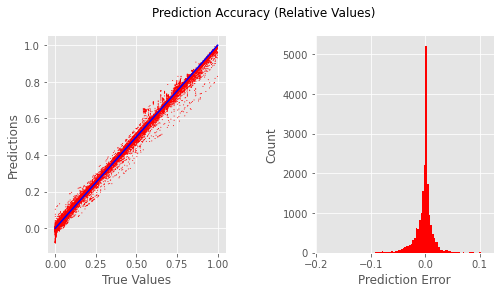

In [22]:
# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)



#Along a line
test_predictions_relative =  model_improved.predict(X_test_call_to_basket_scaled).flatten('F')/np.concatenate((np.array(X_test_call.iloc[:,0]),np.array(X_test_call.iloc[:,0])))
y_test_relative =  np.array(y_test_call).flatten('F')/np.concatenate((np.array(X_test_call.iloc[:,0]),np.array(X_test_call.iloc[:,0])))

#a = plt.axes(aspect='equal')
axs[0].plot([0,max(test_predictions_relative)],[0,max(test_predictions_relative)],color = "blue")
axs[0].scatter(y_test_relative, test_predictions_relative,c=['red']*len(y_test_call)*2,s=1, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')


# Histogram
error = np.array(test_predictions_relative - y_test_relative)
axs[1].hist(error, bins = 100,color='red')
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy (Relative Values)')
plt.savefig('accuracy_relative_spot_call_options_basket_to_calls_2.eps', format='eps')

# Evaluate the model
print("Model Evaluation \n \nRelative Mean absolute Error:")
print(np.mean(np.abs(test_predictions_relative - y_test_relative)))

# Evaluate the model
print("Model Evaluation \n \nRelative Mean squared Error:")
print(np.mean(np.square(test_predictions_relative - y_test_relative)))

## Eventually we test the performance on basket options

In [23]:
test_predictions_improved_bskts = model_improved.predict(X_test_basket_scaled)
weighted_spot = X_test_basket.iloc[:,0]*X_test_basket.iloc[:,2]+X_test_basket.iloc[:,1]*X_test_basket.iloc[:,3]

mae_basket_improved_bskts = np.mean(np.mean(np.abs(test_predictions_improved_bskts-y_test_basket_prices)))
rae_basket_improved_bskts = np.sum(np.sum(np.abs(test_predictions_improved_bskts-y_test_basket_prices)/np.reshape(np.repeat([weighted_spot],2),(len(X_test_basket),2)),1),0)/(2*len(y_test_basket_prices))
rse_basket_improved_bskts = np.sum(np.sum(np.square((test_predictions_improved_bskts-y_test_basket_prices)/np.reshape(np.repeat([weighted_spot],2),(len(X_test_basket),2))),1),0)/(2*len(y_test_basket_prices))
print("-- Improved Strategy: --\n")
print("mean absolute error:{}\n".format(mae_basket_improved_bskts))
print("relative mean absolute error:{}\n".format(rae_basket_improved_bskts))
print("relative mean squared error:{}\n".format(rse_basket_improved_bskts))

-- Improved Strategy: --

mean absolute error:4.124453584410784

relative mean absolute error:0.02923406830135228

relative mean squared error:0.03741885558549796

